<a href="https://colab.research.google.com/github/opopiol/ML_project/blob/model/model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [30]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.dummy import DummyClassifier
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn import svm
from imblearn.over_sampling import SMOTE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier
import io
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
from sklearn.manifold import TSNE

In [35]:
%pip install --upgrade --quiet neptune-client
#pip install neptune-notebooks

     |████████████████████████████████| 245kB 3.7MB/s 
     |████████████████████████████████| 829kB 4.7MB/s 
     |████████████████████████████████| 71kB 4.4MB/s 
     |████████████████████████████████| 174kB 8.2MB/s 
     |████████████████████████████████| 71kB 4.3MB/s 
     |████████████████████████████████| 133kB 8.4MB/s 
     |████████████████████████████████| 71kB 5.1MB/s 


In [36]:
import neptune.new as neptune
#run = neptune.init(project='opopiol/ML-project')
run = neptune.init(project='opopiol/ML-project',
                   api_token='eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiI5YjIyYjU2ZS0wMTc5LTQ3NWUtOWZkZC05OTg2YzI1M2VkNDUifQ==') # your credentials

run["JIRA"] = "NPT-952"
run["parameters"] = {"learning_rate": 0.001,
                     "optimizer": "Adam"}

for epoch in range(100):
   run["train/loss"].log(epoch * 0.4)
run["eval/f1_score"] = 0.66

Info (NVML): Driver Not Loaded. GPU usage metrics may not be reported. For more information, see https://docs-legacy.neptune.ai/logging-and-managing-experiment-results/logging-experiment-data.html#hardware-consumption 


https://app.neptune.ai/opopiol/ML-project/e/MLPROJ-3
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#import train dataset
train_path = '/content/drive/MyDrive/project/train_data.csv'
train_data = pd.read_csv(train_path, header=None)

In [4]:
#import labels
labels_path = '/content/drive/MyDrive/project/train_labels.csv'
labels = pd.read_csv(labels_path, header=None,  names=['y'])

In [5]:
#import test dataset
test_path = '/content/drive/MyDrive/project/test_data.csv'
test_data = pd.read_csv(test_path, header=None)

In [6]:
X, y = train_data, labels
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, stratify=y)

### EDA

In [7]:
y.value_counts()

y 
 1    3375
-1     375
dtype: int64

In [8]:
y = y['y'].apply(lambda x: 0 if x == -1 else 1)

In [9]:
y.value_counts()

1    3375
0     375
Name: y, dtype: int64

In [10]:
X_train.shape

(2812, 10000)

In [11]:
y_train.shape

(2812, 1)

In [12]:
#scaling data

#StandardScaler
scaler = StandardScaler()

X_train_scale = StandardScaler().fit_transform(X_train)
y_train_scale = scaler.fit_transform(y_train)

In [13]:
#MinMaxScaler
minmaxscaler = MinMaxScaler()
X_train_minmaxscaler = MinMaxScaler().fit_transform(X_train)

In [14]:
X_train_scale.mean(axis=0)

#X_train_scale has now unit variance and zero mean

array([ 9.47558769e-18,  4.35877034e-17,  1.38975286e-17, ...,
       -1.89511754e-18, -1.13707052e-17, -3.79023508e-18])

In [15]:
#PCA

pca = PCA(n_components=2, whiten=True)
X_pca = pca.fit_transform(X_train_scale)

In [16]:
y_train = y_train['y'].apply(lambda x: 0 if x == -1 else 1)

In [17]:
#final_pca_df = pd.DataFrame(data = X_pca)
#final_pca = pd.concat([final_pca_df, y_train], axis = 1)
#final_pca

In [18]:
sns.set_palette('Set1')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


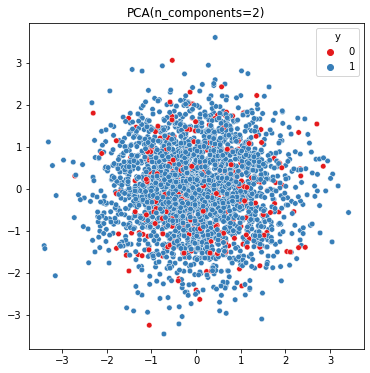

In [19]:
plt.figure(figsize=(6,6))
plt.title('PCA(n_components=2)')
sns.scatterplot(X_pca[:,0],
           X_pca[:,1], 
           s=30, hue=y_train);



/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


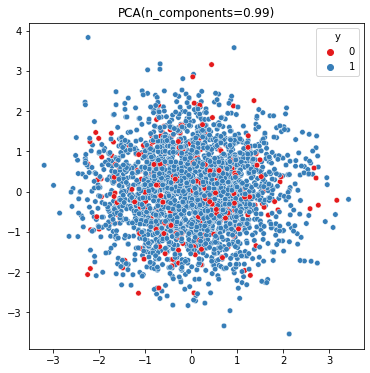

In [20]:
#PCA

pca = PCA(n_components=0.99, whiten=True)
X_pca = pca.fit_transform(X_train_scale)

plt.figure(figsize=(6,6))
plt.title('PCA(n_components=0.99)')
sns.scatterplot(X_pca[:,0],
           X_pca[:,1], 
           s=30, hue=y_train);

In [42]:
pca = PCA()
tsne = TSNE()

def clustering_scatterplot(a, b):
  """This function creates scatterplot with clusters from seaborn's library
    :param a: n_components for PCA
    :param b: n_components for TSNE
    :return: sns.scatterplot(X_p[:,0], X_p[:,1], c=y): scatterplot with clusters
    """
  pipeline = Pipeline([('pca', PCA(n_components = a)), ('tsne', TSNE(n_components = b))])
  X_p = pipeline.fit_transform(X)

  sns.scatterplot(X_p[:,0], X_p[:,1], c=y)
  plt.title(f'PCA(n_components={a})&TSNE(n_components={b})');

W ten sposób t-SNE mapuje dane wielowymiarowe do przestrzeni o niższych wymiarach i próbuje znaleźć wzorce w danych, identyfikując obserwowane klastry na podstawie podobieństwa punktów danych o wielu cechach. Jednak po tym procesie cechy wejściowe nie są już identyfikowalne i nie można wnioskować wyłącznie na podstawie danych wyjściowych t-SNE. Jest to więc głównie technika eksploracji i wizualizacji danych. 

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


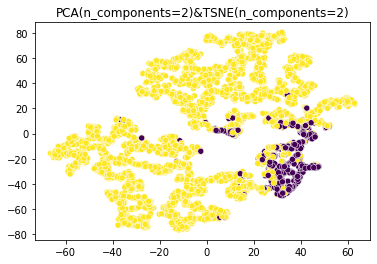

In [43]:
clustering_scatterplot(2, 2)

In [ ]:
#best for our project with n_components=0.99 for PCA and n_components=2 for TSNE
clustering_scatterplot(0.99, 2)

In [ ]:
clustering_scatterplot(0.95, 2)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


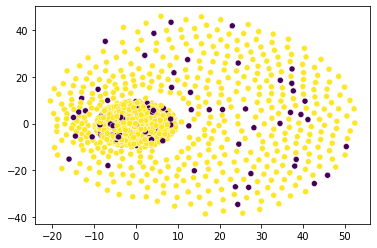

In [25]:
pipeline = Pipeline([('scaler', StandardScaler()), ('pca', PCA(n_components=0.99)), ('tsne', TSNE(n_components=2))])
X_p = pipeline.fit_transform(X)

sns.scatterplot(X_p[:,0],
           X_p[:,1], c=y);

y_pred = pipeline.predict(X_test)
accuracy_score(y_test, y_pred)
print(accuracy_score(y_test, y_pred))

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


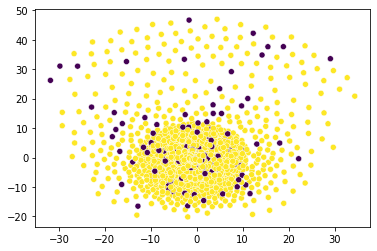

In [26]:
pipeline = Pipeline([('minmaxscaler', MinMaxScaler()), ('pca', PCA(n_components=0.99)), ('tsne', TSNE(n_components=2))])
X_p = pipeline.fit_transform(X)

sns.scatterplot(X_p[:,0],
           X_p[:,1], c=y);

In [27]:
pca = PCA(n_components=0.99, whiten=True)
X_pca = pca.fit_transform(X_train_scale)
X_pca1 = X_pca.map(lambda i: np.log(i) if i > 0 else 0) 
sns.boxplot(data=X,x=X_pca1);

AttributeError: ignored

In [ ]:
Q1,Q3 = np.percentile(X_pca , [25,75])
IQR = Q3 - Q1
IQR

lower_whisker = Q1-1.5*IQR
upper_whisker = Q3+1.5*IQR

df1 = [x for x in X_pca if (Q1 < x < Q3)]
sns.scatterplot(df1[:,0],
           df1[:,1], c=y);

## MODEL

For stratified strategy score is 0.8278805120910384 with labels: [0 1]
For most_frequent strategy score is 0.9000711237553343 with labels: [1]
For prior strategy score is 0.9000711237553343 with labels: [1]
For uniform strategy score is 0.4946657183499289 with labels: [0 1]


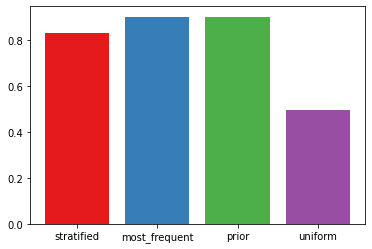

In [37]:
#baseline
strategies = ['stratified', 'most_frequent', 'prior', 'uniform']

for i in strategies:
    dummy_clf = DummyClassifier(strategy=i)
    dummy_clf.fit(X_train, y_train)
    score = dummy_clf.score(X_train, y_train)
    dummy_labels = np.unique(dummy_clf.predict(X_test))
    print(f'For {i} strategy score is {score} with labels: {dummy_labels}')
    plt.bar(i, score)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression 0.802771855010661
KNeighborsClassifier 0.8869936034115139
SVC 0.8795309168443497


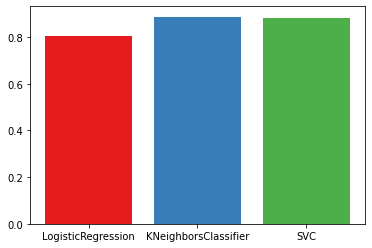

In [39]:
log_clf = LogisticRegression(random_state=0)
knn_clf = KNeighborsClassifier()
svm_clf = SVC()
#voting_clf = VotingClassifier()

clf_list = [log_clf, knn_clf, svm_clf]

def clf_scores(list):
  """This function shows scores and plot with scores of the classifiers given in the list
    :param list: list of classifiers
    :return: print(clf.__class__.__name__, accuracy_score(y_test, y_pred)): scores of the classifiers given in the list
    :return: plt.bar(clf.__class__.__name__, accuracy_score(y_test, y_pred)): plot with scores of the classifiers given in the list
    """
  for clf in list:
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))
    plt.bar(clf.__class__.__name__, accuracy_score(y_test, y_pred));

clf_scores(clf_list)

In [ ]:
#RandomForestClassifier

rnf = RandomForestClassifier().fit(X, y)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
#DecisionTreeClassifier

dtc = DecisionTreeClassifier().fit(X, y)

In [ ]:
#creating pipeline

pipe = Pipeline([('pca', pca), ('scaler', scaler), 
                ('classifier', SVC())
            ])


search_space = [{'scaler': [StandardScaler()],
                'pca': [PCA()]},
                {'classifier': [SVC()],
                 'classifier__kernel': ['linear', 'poly'],
                 'classifier__class_weight': [None, 'balanced'],
                 'classifier__gamma': ['scale', 'auto'],
                 'classifier__C': np.logspace(1,4,10)},
                {'classifier': [KNeighborsClassifier()],
                 'classifier__n_neighbors': [2, 4, 6, 8, 10, 20],
                 'classifier__algorithm': ['auto']}]

In [ ]:
grid_search = GridSearchCV(pipe,
                           search_space,
                           cv=5,
                           verbose=2,
                           n_jobs=-2,
                           scoring='balanced_accuracy')


In [ ]:
#best_model = grid_search.fit(X, y.values)

In [ ]:
from hyperopt import hp, fmin, tpe, STATUS_OK, space_eval
from hyperopt import Trials

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

rnd_clsf = RandomizedSearchCV(pipe,
                           search_space,
                           cv=5,
                           verbose=2,
                           n_jobs=-2,
                           scoring='balanced_accuracy')

In [ ]:
best_model = rnd_clsf.fit(X, y.values)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] classifier__kernel=poly, classifier__gamma=scale, classifier__class_weight=balanced, classifier__C=10000.0, classifier=SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False) 


[Parallel(n_jobs=-2)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  classifier__kernel=poly, classifier__gamma=scale, classifier__class_weight=balanced, classifier__C=10000.0, classifier=SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False), total= 1.5min
[CV] classifier__kernel=poly, classifier__gamma=scale, classifier__class_weight=balanced, classifier__C=10000.0, classifier=SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False) 


[Parallel(n_jobs=-2)]: Done   1 out of   1 | elapsed:  1.5min remaining:    0.0s


[CV]  classifier__kernel=poly, classifier__gamma=scale, classifier__class_weight=balanced, classifier__C=10000.0, classifier=SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False), total= 1.5min
[CV] classifier__kernel=poly, classifier__gamma=scale, classifier__class_weight=balanced, classifier__C=10000.0, classifier=SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False) 
[CV]  classifier__kernel=poly, classifier__gamma=scale, classifier__class_weight=balanced, classifier__C=10000.0, classifier=SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', 

In [ ]:

from sklearn.model_selection import cross_val_score
score = cross_val_score(pipeline, X, y, cv=10, scoring="accuracy").mean()

AttributeError: ignored

In [ ]:
https://blog.prokulski.science/2020/12/23/hyperopt-scikit-learn/

In [ ]:
#choosing best model

print(best_model.best_estimator_)
print("The mean accuracy of the model is:",best_model.score(X, y))

Pewnie nie muszę przypominać, że podczas poszukiwania parametrów, oceny klasyfikatora powinniśmy dokonywać na danych, które nie były wykorzystywane do treningu. W przeciwnym wypadku padamy ofiarą przeuczenia (ang. overfittingu), czyli dostosowania się algorytmu do naszego zbioru. Obliczony model będzie działał rewelacyjnie na danych treningowych, ale już na rzeczywistych będziemy osiągali słabe wyniki. Najłatwiej można poradzić sobie na dwa sposoby:

    Podzielić zbiór treningowy na dwie części, służącą do treningu (train dataset) oraz walidacyjną (validation dataset). Poszukiwanie parametrów uruchamiać na części treningowej a ocenę przeprowadzić na części walidacyjnej.

estimators = {'LogisticRegression': {'estimator': LogisticRegression(),
                                     'estimator__penalty':['l1', 'l2', 'elasticnet', 'none'],
                                     'estimator__class_weight': ['balanced'],
                                     'estimator__C': np.logspace(0, 4, 10000),
                                     'estimator__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']},
              'LinearDiscriminantAnalysis': {'estimator': LinearDiscriminantAnalysis(),
                                             'estimator__solver': ['svd', 'lsqr', 'eigen']},
              'QuadraticDiscriminantAnalysis' :{'estimator': QuadraticDiscriminantAnalysis()},
              'GaussianNB': {'estimator': GaussianNB()},
              'BernoulliNB': {'estimator': BernoulliNB(),
                              'estimator__alpha': np.logspace(0,1,10, endpoint=False)/10},
              'DecisionTreeClassifier': {'estimator': DecisionTreeClassifier(),
                                         'estimator__criterion': ['gini', 'entropy'],
                                         'estimator__class_weight': ['balanced'],
                                         'estimator__splitter': ['best', 'random'],
                                         'estimator__max_depth': [2,5,10,None]},
              'SVC': {'estimator': SVC(),
                      'estimator__C': np.logspace(0, 4, 10000),
                      'estimator__class_weight': ['balanced'],
                      'estimator__kernel': ['linear', 'poly', 'rbf', 'sigmoid', 'precomputed'],
                      'estimator__gamma': ['scale', 'auto']},
              'LinearSVC': {'estimator': LinearSVC(),
                            'estimator__penalty': ['l1','l2'],
                            'estimator__loss': ['hinge', 'squared_hinge'],
                            'estimator__class_weight': ['balanced'],
                            'estimator__C': np.logspace(0, 4, 10000)},
              'NuSVC': {'estimator': NuSVC(),
                        'estimator__kernel': ['linear', 'poly', 'rbf', 'sigmoid', 'precomputed'],
                        'estimator__gamma': ['scale', 'auto'],
                        'estimator__class_weight': ['balanced']},
              'OneClassSVM': {'estimator': OneClassSVM(),
                              'estimator__kernel': ['linear', 'poly', 'rbf', 'sigmoid', 'precomputed'],
                              'estimator__gamma': ['scale', 'auto'],
                              'estimator__class_weight': ['balanced']},
              'RandomForestClassifier': {'estimator': RandomForestClassifier(),
                                         'estimator__n_estimators': [10,20,50,100,200,500,1000],
                                         'estimator__criterion': ['gini', 'entropy'],
                                         'estimator__max_depth': [2,5,10,None],
                                         'estimator__max_features': ['auto', 'sqrt', 'log2'],
                                         'estimator__class_weight': ['balanced', 'balanced_subsample']},
              'IsolationForest': {'estimator': IsolationForest(),
                                  'estimator__n_estimators': [10,20,50,100,200,500,1000]},
              'GradientBoostingClassifier': {'estimator': GradientBoostingClassifier(),
                                             'estimator__n_estimators': [10,20,50,100,200,500,1000],
                                             'estimator__learning_rate': np.logspace(0,1,10, endpoint=False)/10,
                                             'estimator__criterion': ['friedman_mse', 'mse', 'mae'],
                                             'estimator__max_features': ['auto', 'sqrt', 'log2']}
             }